<a href="https://colab.research.google.com/github/AUT-Student/NLP-HW2/blob/main/NLP_HW2_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix 
import seaborn as sn

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Bidirectional, TimeDistributed
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import backend

# Dataset

In [2]:
!gdown 1Px1lQhMgkdeFigxwmqvk1ojJPZpq40u5
!gdown 1WHbpY1Ydqq7yqtQ2YFavR78zsD7nDwbg
!gdown 1pMJQk75R3898sUzFKUMQTPPE_QlllvAY
!gdown 1NMesvM67oiJ6-PpSbtErFanj0JMl_Z50

Downloading...
From: https://drive.google.com/uc?id=1Px1lQhMgkdeFigxwmqvk1ojJPZpq40u5
To: /content/UPC_2016_train.txt
100% 25.4M/25.4M [00:00<00:00, 55.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WHbpY1Ydqq7yqtQ2YFavR78zsD7nDwbg
To: /content/UPC_2016_val.txt
100% 5.47M/5.47M [00:00<00:00, 44.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pMJQk75R3898sUzFKUMQTPPE_QlllvAY
To: /content/UPC_2016_test.txt
100% 5.48M/5.48M [00:00<00:00, 99.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NMesvM67oiJ6-PpSbtErFanj0JMl_Z50
To: /content/vectors.zip
100% 48.2M/48.2M [00:00<00:00, 52.1MB/s]


In [3]:
def read_dataset(filepath):
  file = open(filepath, "r")

  dataset = [[]]

  item_counter = 0
  end_line = False
  for line in file.readlines():
    line_splitted = line.split()
    if len(line_splitted) == 2:  
      token, tag = line_splitted
      
      dataset[-1].append((token, tag))
    else:
      dataset.append([])
      item_counter += 1

  return dataset[:-1]

In [4]:
train_dataset = read_dataset("/content/UPC_2016_train.txt")
valid_dataset = read_dataset("/content/UPC_2016_val.txt")
test_dataset = read_dataset("/content/UPC_2016_test.txt")

In [5]:
!unzip /content/vectors.zip

Archive:  /content/vectors.zip
  inflating: vectors.txt             


# Dataset Overview

In [6]:
print("Max Length:")
print("train = ", max([len(data) for data in train_dataset]))
print("test  = ", max([len(data) for data in test_dataset]))
print("valid = ", max([len(data) for data in valid_dataset]))

print("\nAvg Length:")
print("train = ", np.mean([len(data) for data in train_dataset]))
print("test  = ", np.mean([len(data) for data in test_dataset]))
print("valid = ", np.mean([len(data) for data in valid_dataset]))

Max Length:
train =  734
test  =  734
valid =  676

Avg Length:
train =  29.24276051743712
test  =  29.4551559468736
valid =  29.323931049921647


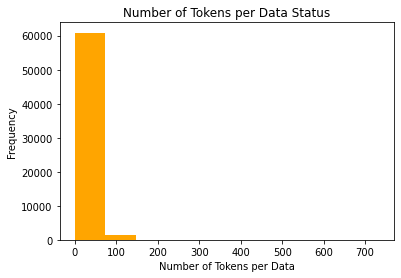

In [7]:
plt.title("Number of Tokens per Data Status")
plt.xlabel("Number of Tokens per Data")
plt.ylabel("Frequency")
plt.hist([len(data) for data in train_dataset], color="orange")
plt.show()

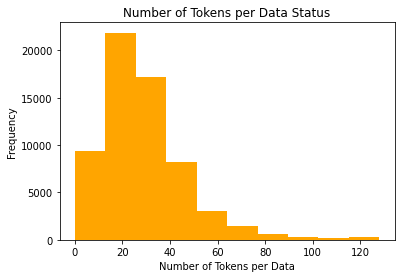

In [8]:
plt.title("Number of Tokens per Data Status")
plt.xlabel("Number of Tokens per Data")
plt.ylabel("Frequency")
plt.hist([min(len(data), 128) for data in train_dataset], color="orange")
plt.show()

In [9]:
print(f"Percent of Long-tail data = {sum([len(data)>64 for data in train_dataset]) * 100 / len(train_dataset)} %")

Percent of Long-tail data = 4.362078063288508 %


# Split Long Data

In [10]:
max_length = 64

In [11]:
def split_long_data(dataset, max_length):
  new_dataset = []
  for data in dataset:
    number_new_data = math.ceil(len(data)/max_length)

    for i in range(number_new_data):
      new_dataset.append(data[i*max_length : min((i+1)*max_length, len(data))])

  return new_dataset

In [12]:
train_dataset = split_long_data(train_dataset, max_length)
test_dataset = split_long_data(test_dataset, max_length)
valid_dataset = split_long_data(valid_dataset, max_length)

# Tag to Index

In [13]:
all_tag = set()

for data in train_dataset:
  for item in data:
    tag = item[1]
    all_tag.add(tag)

In [14]:
tag2index = {tag:i+1 for i, tag in enumerate(all_tag)}
tag2index["PAD"] = 0

# Word to Vec 

In [15]:
file = open("/content/vectors.txt", "r")

word2vector = {}

for i, line in enumerate(file.readlines()):
  line_splitted = line.split()
  word = line_splitted[0]
  vector = np.array(line_splitted[1:], dtype="float")

  word2vector[word] = vector

In [16]:
embedding_size = len(word2vector['#1'])

# Digitalize & Padding

In [18]:
def preprocess(dataset, max_length, embedding_size):
  digitalized_dataset = []
  dataset_X = []
  dataset_y = []

  for data in dataset:
    dataset_X.append([])
    dataset_y.append([])

    for item in data:
      vector = word2vector.get(item[0], np.zeros(embedding_size))
      tag_index = tag2index[item[1]]
      dataset_X[-1].append(vector)
      dataset_y[-1].append(tag_index)

    for _ in range(max_length-len(dataset_y[-1])):
      dataset_y[-1].append(0)
      dataset_X[-1].append(np.zeros(embedding_size))

  dataset_X = np.array(dataset_X)
  dataset_y = np.array(dataset_y)

  return dataset_X, dataset_y

In [19]:
train_X, train_y = preprocess(train_dataset, max_length, embedding_size)
test_X, test_y = preprocess(test_dataset, max_length, embedding_size)
valid_X, valid_y = preprocess(valid_dataset, max_length, embedding_size)

# Accuracy Metric

In [20]:
def ignore_class_accuracy(to_ignore=0):
   # Refrence: https://nlpforhackers.io/lstm-pos-tagger-keras/
  
  def ignore_accuracy(y_true, y_pred):
    y_pred_class = backend.argmax(y_pred, axis=-1)
    y_true_class = backend.argmax(y_true, axis=-1)
    y_true_class = backend.cast(y_true, "int64")

    ignore_mask = backend.cast(backend.not_equal(y_pred_class, to_ignore), 'int32')
    matches = backend.cast(backend.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
    accuracy = backend.sum(matches) / backend.maximum(backend.sum(ignore_mask), 1)
    return accuracy
  
  return ignore_accuracy

# BiLSTM Model

In [21]:
class BiLSTM(keras.Model):
  def __init__(self, max_length, embedding_size, number_tags, lstm_units):
    super().__init__()
    self.model = Sequential([
                             Input((max_length, embedding_size)),
                             Bidirectional(LSTM(lstm_units, return_sequences=True)),
                             TimeDistributed(Dense(number_tags+1, activation="softmax"))
    ])
  
  def call(self, inputs):
    return self.model(inputs)

In [22]:
model = BiLSTM(max_length=max_length, embedding_size=embedding_size, number_tags=len(all_tag), lstm_units=64)

In [23]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy", ignore_class_accuracy(0)])

In [24]:
es_callback = EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=2)

# Training

In [25]:
model.fit(x=train_X, y=train_y, epochs=10, validation_data=(valid_X, valid_y), callbacks=[es_callback])

2054/2054 [==============================] - 180s 85ms/step - loss: 0.3424 - accuracy: 0.9035 - ignore_accuracy: 0.7870 - val_loss: 0.1918 - val_accuracy: 0.9434 - val_ignore_accuracy: 0.8728


# Evalluation & Report

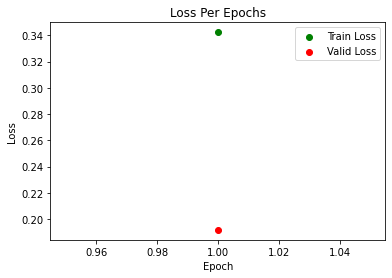

In [26]:
plt.title("Loss Per Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

train_loss_list = model.history.history["loss"]
valid_loss_list = model.history.history["val_loss"]

epochs = range(1, len(train_loss_list)+1)

plt.scatter(epochs, train_loss_list, label="Train Loss", color="green")
plt.scatter(epochs, valid_loss_list, label="Valid Loss", color="red")

plt.plot(epochs, train_loss_list, color="green")
plt.plot(epochs, valid_loss_list, color="red")

plt.legend()

plt.show()

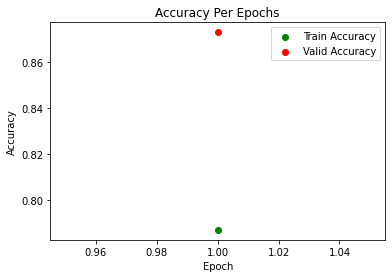

In [27]:
plt.title("Accuracy Per Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

train_accuracy_list = model.history.history["ignore_accuracy"]
valid_accuracy_list = model.history.history["val_ignore_accuracy"]

epochs = range(1, len(train_accuracy_list)+1)

plt.scatter(epochs, train_accuracy_list, label="Train Accuracy", color="green")
plt.scatter(epochs, valid_accuracy_list, label="Valid Accuracy", color="red")

plt.plot(epochs, train_accuracy_list, color="green")
plt.plot(epochs, valid_accuracy_list, color="red")

plt.legend()

plt.show()

In [28]:
model.evaluate(train_X, train_y)
model.evaluate(valid_X, valid_y)
model.evaluate(test_X, test_y)

441/441 [==============================] - 11s 25ms/step - loss: 0.1964 - accuracy: 0.9421 - ignore_accuracy: 0.8715


[0.19642236828804016, 0.9420931339263916, 0.8715178966522217]

In [29]:
test_yp = model.predict(test_X).argmax(-1)

In [30]:
precision, recall, fscore, support = precision_recall_fscore_support(test_y.flatten(), test_yp.flatten())

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
precision

array([0.99690794, 0.97049209, 0.78861095, 0.89222615, 0.        ,
       0.91455696, 0.90316986, 0.74520384, 0.82312047, 0.97346311,
       0.79508215, 0.88490898, 0.94701299, 0.78813559, 0.        ,
       0.86096257, 0.6440678 , 0.80973999, 0.90205815, 0.875     ,
       0.        , 0.92244418, 0.92547285, 0.        , 0.6766055 ,
       0.99981604, 0.95840979, 0.87582368, 0.80679287, 0.        ,
       0.        ])

In [32]:
recall

array([0.99916125, 0.96198678, 0.76238032, 0.52008239, 0.        ,
       0.59710744, 0.92318298, 0.71962617, 0.68524184, 0.97173782,
       0.93397408, 0.80416222, 0.89494354, 0.44391408, 0.        ,
       0.55231561, 0.30438048, 0.82385051, 0.86021136, 0.12650602,
       0.        , 0.68083261, 0.89531179, 0.        , 0.52867384,
       0.99981604, 0.80358974, 0.90266648, 0.65625   , 0.        ,
       0.        ])

In [33]:
confusion = confusion_matrix(test_y.flatten(), test_yp.flatten())

In [34]:
confusion = confusion[1: , 1:]

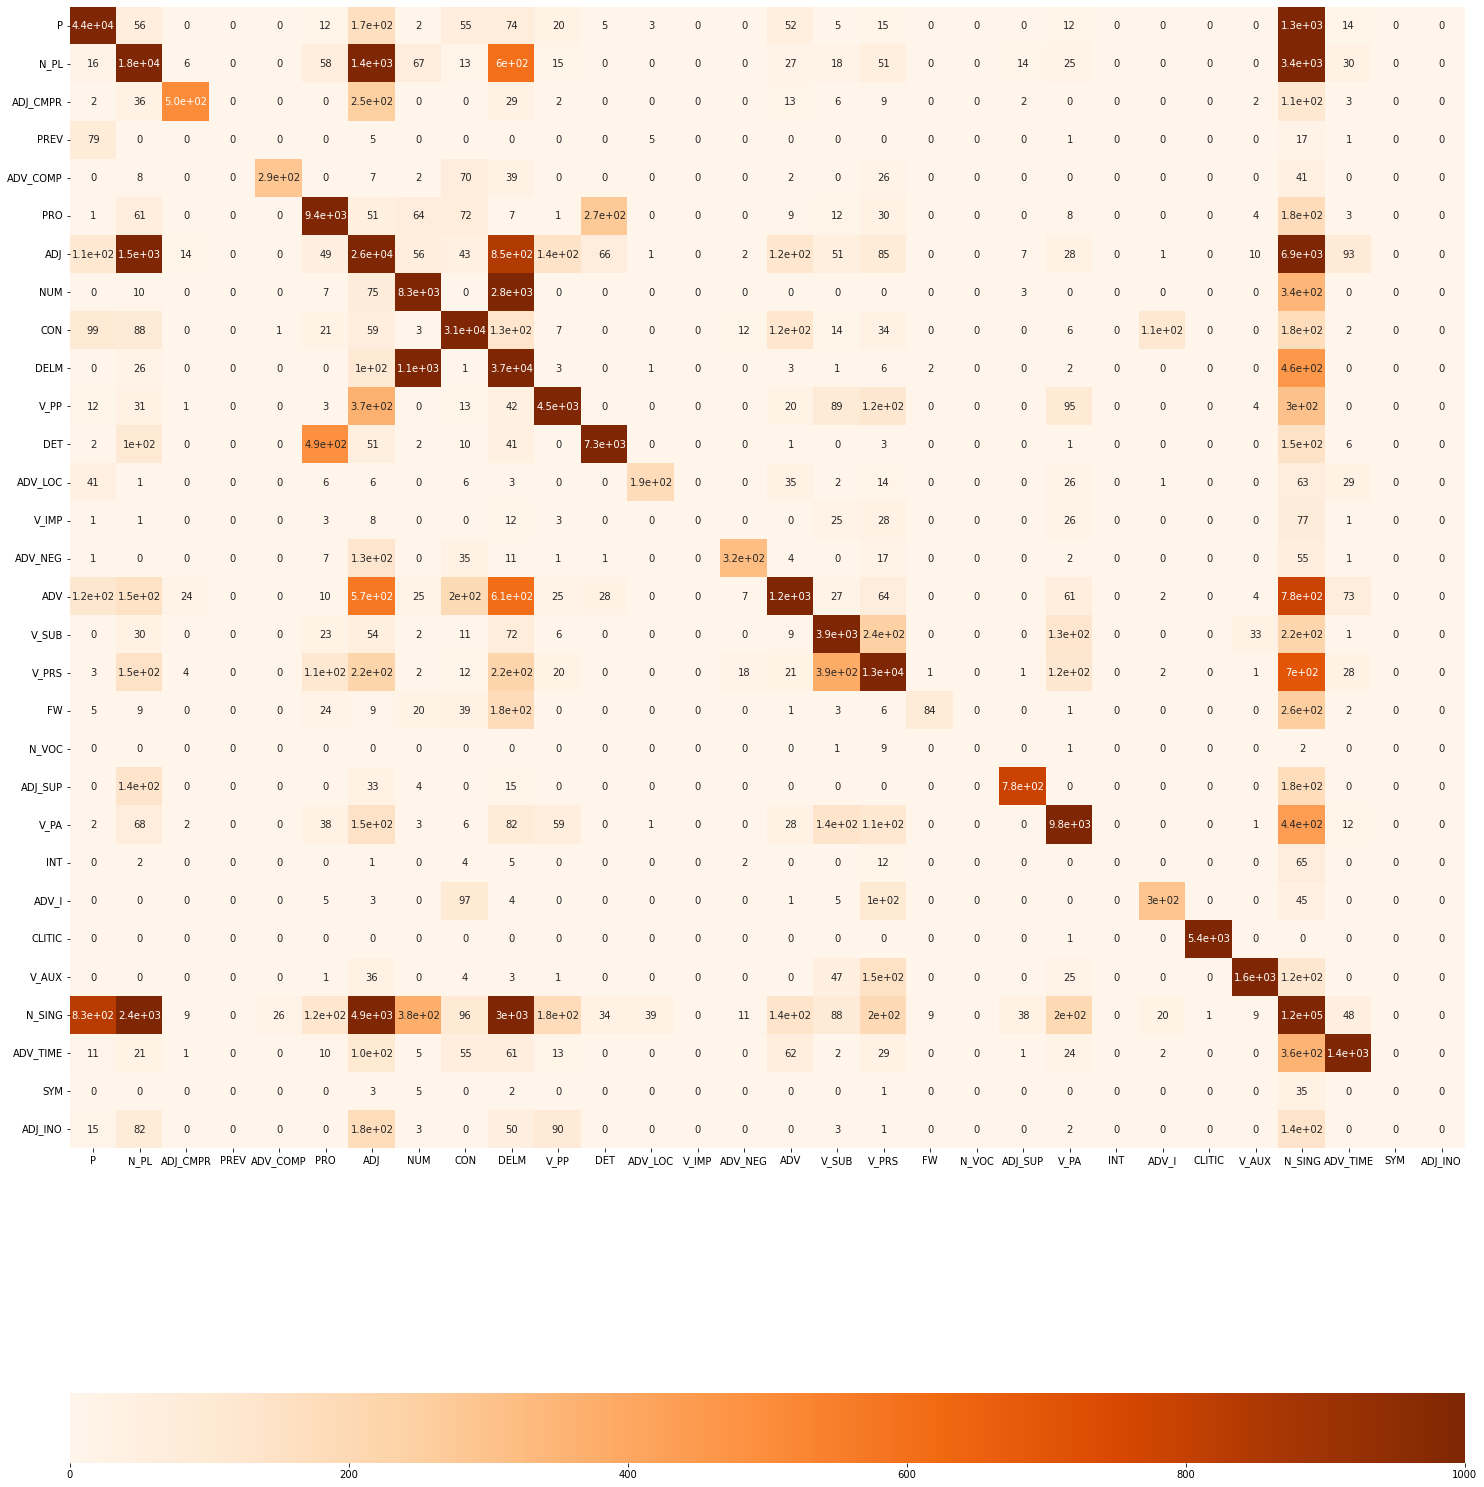

In [73]:
df_cm = pd.DataFrame(confusion, index = [i for i in all_tag],
                     columns = [i for i in all_tag])

plt.figure(figsize = (25,30))
sn.heatmap(df_cm, annot=True, cbar_kws={"orientation": "horizontal"}, vmax=1000, cmap="Oranges")
plt.show()

In [43]:
index2tag = {v:k for k, v in tag2index.items()}

In [50]:
for irow, row in enumerate(confusion):
  for icol, cell in enumerate(row):
    if irow != icol and cell>1000:
      print(f"True Tag = {index2tag[icol+1]} | Predicted Tag = {index2tag[irow+1]} | Error Number = {cell}")

True Tag = N_SING | Predicted Tag = P | Error Number = 1256
True Tag = ADJ | Predicted Tag = N_PL | Error Number = 1402
True Tag = N_SING | Predicted Tag = N_PL | Error Number = 3407
True Tag = N_PL | Predicted Tag = ADJ | Error Number = 1521
True Tag = N_SING | Predicted Tag = ADJ | Error Number = 6901
True Tag = DELM | Predicted Tag = NUM | Error Number = 2805
True Tag = NUM | Predicted Tag = DELM | Error Number = 1140
True Tag = N_PL | Predicted Tag = N_SING | Error Number = 2365
True Tag = ADJ | Predicted Tag = N_SING | Error Number = 4885
True Tag = DELM | Predicted Tag = N_SING | Error Number = 3038


In [53]:
recall_confusion = confusion_matrix(test_y.flatten(), test_yp.flatten(), normalize="true")
precision_confusion = confusion_matrix(test_y.flatten(), test_yp.flatten(), normalize="pred")

In [60]:
for irow, row in enumerate(confusion):
  for icol, cell in enumerate(row):
    if confusion[irow][icol]>0 and irow != icol:
      if recall_confusion[irow][icol] > 0.10: 
        print(f"True Tag = {index2tag[icol+1]} | Predicted Tag = {index2tag[irow+1]} | Error Number = {cell}")
      if precision_confusion[irow][icol] > 0.10:
        print(f"True Tag = {index2tag[icol+1]} | Predicted Tag = {index2tag[irow+1]} | Error Number = {cell}")

True Tag = ADV_TIME | Predicted Tag = ADJ_CMPR | Error Number = 3
True Tag = ADV_TIME | Predicted Tag = PREV | Error Number = 1
True Tag = N_PL | Predicted Tag = ADV_COMP | Error Number = 8
True Tag = DELM | Predicted Tag = PRO | Error Number = 7
True Tag = V_PP | Predicted Tag = CON | Error Number = 7
True Tag = CON | Predicted Tag = V_PP | Error Number = 13
True Tag = ADV_TIME | Predicted Tag = V_IMP | Error Number = 1
True Tag = V_PRS | Predicted Tag = ADV_NEG | Error Number = 17
True Tag = ADV_TIME | Predicted Tag = ADV_NEG | Error Number = 1
True Tag = NUM | Predicted Tag = ADV | Error Number = 25
True Tag = NUM | Predicted Tag = V_SUB | Error Number = 2
True Tag = V_PP | Predicted Tag = V_SUB | Error Number = 6
True Tag = ADV_TIME | Predicted Tag = V_SUB | Error Number = 1
True Tag = ADJ_CMPR | Predicted Tag = V_PA | Error Number = 2
True Tag = ADV_TIME | Predicted Tag = V_PA | Error Number = 12
True Tag = ADJ_CMPR | Predicted Tag = ADV_TIME | Error Number = 1
True Tag = NUM | Pr